In [1]:
import pandas as pd
import geopandas as gpd
import json

C:\Users\nicol\AppData\Local\Temp\ipykernel_12848\4081446269.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
gdf = gpd.read_file('onb-v3-2-2-dpt94.gpkg', rows=100_000)

In [3]:
df = gdf.drop(columns=['geometry'])

In [4]:
df_dpe = df[~df['dpe'].isna()]
df_no_dpe = df[df['dpe'].isna()]

Text(0.5, 1.0, 'Number of NaN values for entries without with DPE')

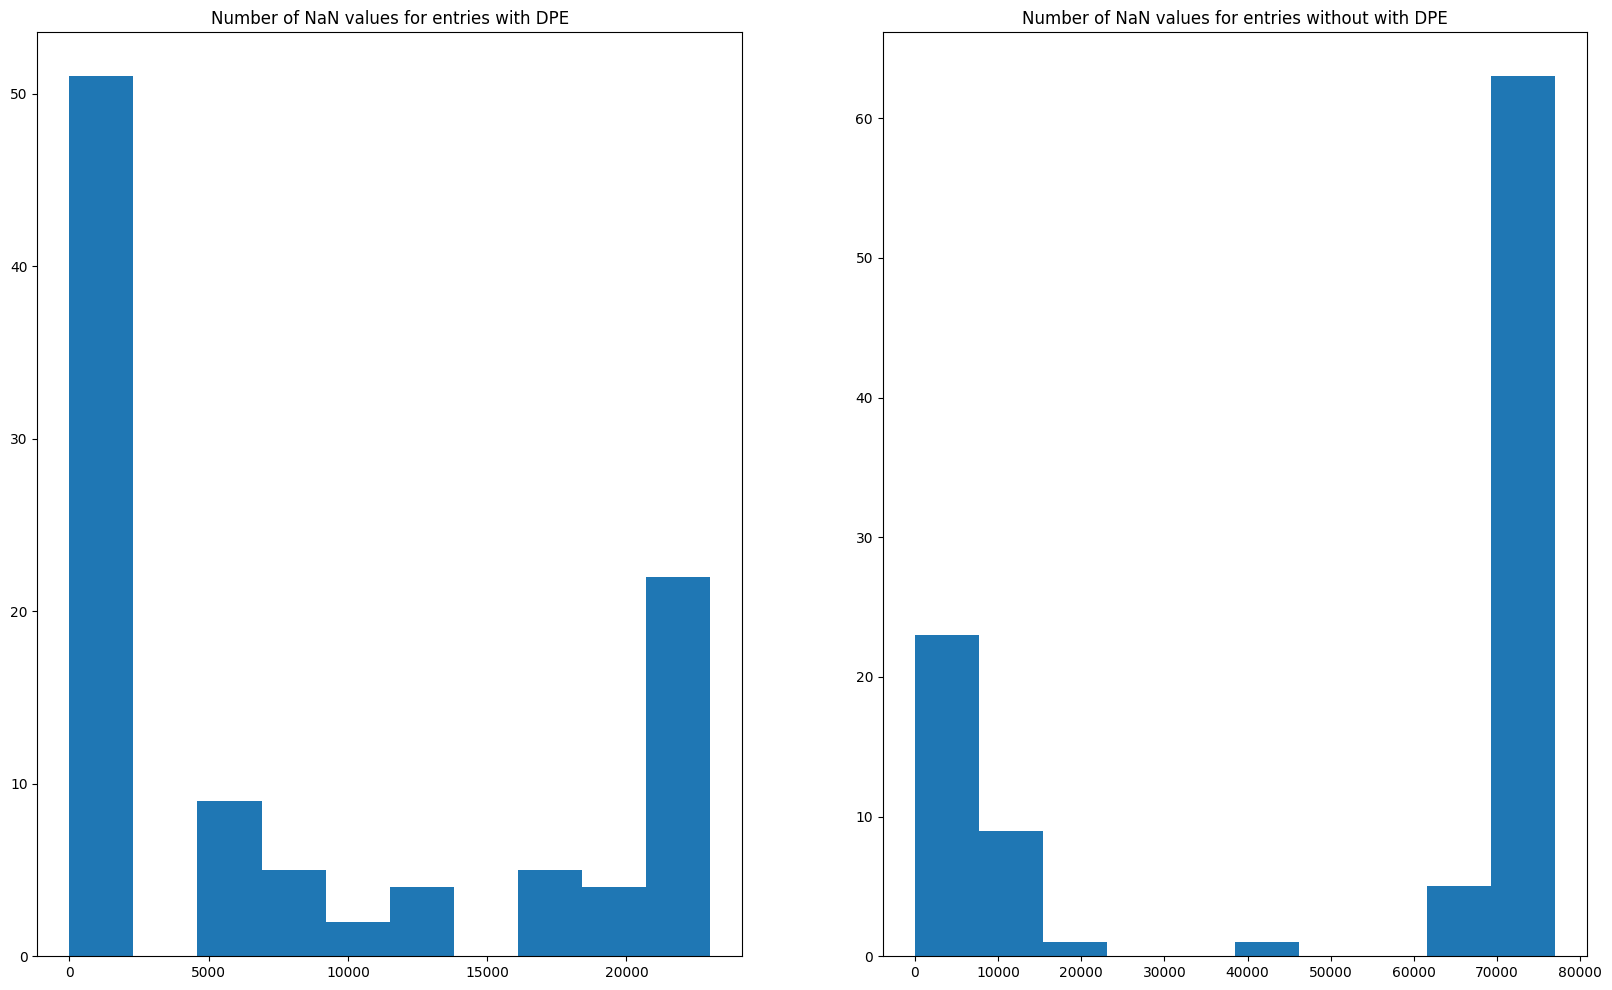

In [5]:
import matplotlib.pyplot as plt

# Plot the histograms of missing values for each df
dico_dpe = df_dpe.isna().sum().to_dict()
values_dpe = list(dico_dpe.values())
dico_no_dpe = df_no_dpe.isna().sum().to_dict()
values_no_dpe = list(dico_no_dpe.values())
fig, ax = plt.subplots(1, 2, figsize = (20,12))
ax[0].hist(values_dpe)
ax[0].set_title('Number of NaN values for entries with DPE')
ax[1].hist(values_no_dpe)
ax[1].set_title('Number of NaN values for entries without with DPE')

We see that we lack a lot of informations for the entries without DPEs. Let's proceed with only the columns we have most of the time even when we don't have the DPE.

In [6]:
def remove_nan_columns(df, threshold):

    # Select only colums that don't hold too many NaN values
    threshold_count = len(df) * threshold
    nan_count = df.isna().sum()
    columns_to_keep = nan_count[nan_count <= threshold_count].index.tolist()

    # Create a new DataFrame with selected columns
    cleaned_df = df[columns_to_keep]

    return cleaned_df, columns_to_keep

In [7]:
cleaned_df_no_dpe, columns_to_keep = remove_nan_columns(df_no_dpe, threshold=0.3)
cleaned_df_no_dpe['dpe'] = df_no_dpe['dpe']
columns_to_keep += ['dpe']
cleaned_df_dpe = df_dpe[columns_to_keep]

C:\Users\nicol\AppData\Local\Temp\ipykernel_12848\1523480992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df_no_dpe['dpe'] = df_no_dpe['dpe']


In [8]:
non_numerical_colums = []
numerical_columns = []
for c in cleaned_df_no_dpe.columns:
    if str(cleaned_df_no_dpe[c].dtype)== 'object':
        non_numerical_colums.append(c)
    else:
        numerical_columns.append(c)

In [9]:
cleaned_df_no_dpe[non_numerical_colums].head()

,id,adresse,commune,epci,iris,cp,batihist,mur,nivtot,pgaz,...,zoneinond,zoneqpv,zonezsp,epci_id,iris_id,departement_id,commune_id,ban_id,parcelle_id,dpe
0,000AH0044_efec893d9b6f5deb,9 RUE SAINT ETIENNE,Champigny-Sur-Marne,Métropole du Grand Paris/Paris Est Marne et Bois,Bois l'Abbé 2,94500,False,beton,2,non,...,false,False,False,200054781/200057941,940171202,94,94017,94017_8821_00009,94017000AH0044,None
1,000AH0045_9a0eca9a280f6fcf,12 RUE PAPIN,Champigny-Sur-Marne,Métropole du Grand Paris/Paris Est Marne et Bois,Bois l'Abbé 2,94500,False,briques,2,oui,...,false,False,False,200054781/200057941,940171202,94,94017,94017_7114_00012,94017000AH0045,None
10,000AH0043_aa7e3dfc5505299e,1 RUE SAINT ETIENNE,Champigny-Sur-Marne,Métropole du Grand Paris/Paris Est Marne et Bois,Bois l'Abbé 2,94500,False,beton,2,non,...,false,False,False,200054781/200057941,940171202,94,94017,94017_8821_00001,94017000AH0043,None
11,000AH0045_f41b7c22a043da2f,3 IMP SAINT ETIENNE,Champigny-Sur-Marne,Métropole du Grand Paris/Paris Est Marne et Bois,Bois l'Abbé 2,94500,False,briques,2,oui,...,false,False,False,200054781/200057941,940171202,94,94017,94017_8823,94017000AH0045,None
12,000AH0047_ebcb6c942cb5589d,6 RUE PAPIN,Champigny-Sur-Marne,Métropole du Grand Paris/Paris Est Marne et Bois,Bois l'Abbé 2,94500,False,beton,1,oui,...,false,False,False,200054781/200057941,940171202,94,94017,94017_7114_00006,94017000AH0047,None


In [10]:
# For non-numeric columns, only keep columns that have less
# than a threshold number of unique values and transform them into 
# categorical values (between 0 and nb of unique values - 1)
threshold = 16

non_numerical_to_categorical_columns = []
for c in cleaned_df_no_dpe[non_numerical_colums].columns:
    if df[c].unique().shape[0] < threshold:
        non_numerical_to_categorical_columns.append(c)

In [11]:
cleaned_df_no_dpe[non_numerical_to_categorical_columns]

,epci,batihist,pgaz,typehab,typobati,zonehist,zoneinond,zoneqpv,zonezsp,epci_id,departement_id,dpe
0,Métropole du Grand Paris/Paris Est Marne et Bois,False,non,maison,habitation,False,false,False,False,200054781/200057941,94,None
1,Métropole du Grand Paris/Paris Est Marne et Bois,False,oui,maison,habitation,False,false,False,False,200054781/200057941,94,None
10,Métropole du Grand Paris/Paris Est Marne et Bois,False,non,maison,habitation,False,false,False,False,200054781/200057941,94,None
11,Métropole du Grand Paris/Paris Est Marne et Bois,False,oui,maison,habitation,False,false,False,False,200054781/200057941,94,None
12,Métropole du Grand Paris/Paris Est Marne et Bois,False,oui,maison,habitation,False,false,False,False,200054781/200057941,94,None
...,...,...,...,...,...,...,...,...,...,...,...,...
99940,Métropole du Grand Paris/Paris Est Marne et Bois,False,oui,appartement,habitation et activite,False,false,False,False,200054781/200057941,94,None
99941,Métropole du Grand Paris/Paris Est Marne et Bois,False,oui,maison,habitation,False,false,False,False,200054781/200057941,94,None
99942,Métropole du Grand Paris/Paris Est Marne et Bois,False,oui,maison,habitation,True,false,False,False,200054781/200057941,94,None
99943,Métropole du Grand Paris/Paris Est Marne et Bois,False,non,maison,habitation,True,false,False,False,200054781/200057941,94,None


In [12]:
from sklearn.preprocessing import LabelEncoder

### Encode non numeric columns ###

encoders_dict = {}
for c in non_numerical_to_categorical_columns:
    label_encoder = LabelEncoder()
    _ = label_encoder.fit_transform(df[c])
    cleaned_df_no_dpe[c] = label_encoder.transform(cleaned_df_no_dpe[c])
    cleaned_df_dpe[c] = label_encoder.transform(cleaned_df_dpe[c])
    classes = label_encoder.classes_
    ### Makes sure that NaN are mapped to a default token value of -100 ###
    mapping = {i : i for i in range(classes.shape[0])}
    for i in range(classes.shape[0]):
        if str(classes[i]) == 'nan':
            mapping[i] = -100
            break
    cleaned_df_no_dpe[c] = cleaned_df_no_dpe[c].apply(lambda x: mapping[int(x)])
    cleaned_df_dpe[c] = cleaned_df_dpe[c].apply(lambda x: mapping[int(x)])
    encoders_dict[c] = label_encoder

C:\Users\nicol\AppData\Local\Temp\ipykernel_12848\371636619.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df_no_dpe[c] = label_encoder.transform(cleaned_df_no_dpe[c])
C:\Users\nicol\AppData\Local\Temp\ipykernel_12848\371636619.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df_dpe[c] = label_encoder.transform(cleaned_df_dpe[c])
C:\Users\nicol\AppData\Local\Temp\ipykernel_12848\371636619.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [13]:
cleaned_df_dpe[non_numerical_to_categorical_columns].head()

,epci,batihist,pgaz,typehab,typobati,zonehist,zoneinond,zoneqpv,zonezsp,epci_id,departement_id,dpe
2,2,0,0,0,1,0,0,0,0,0,0,4
3,2,0,0,0,2,0,0,0,0,0,0,3
4,2,0,0,0,2,0,0,0,0,0,0,3
5,2,0,0,0,2,0,0,0,0,0,0,3
6,2,0,0,0,2,0,0,0,0,0,0,3


In [15]:
from sklearn.preprocessing import MinMaxScaler

### Min Max the other variables to the same scale
scalers_dict = {}
for c in numerical_columns:
    scaler_encoder = MinMaxScaler(feature_range=(0, threshold-1))
    percentile_5 = df[c].quantile(0.05)
    percentile_95 = df[c].quantile(0.95)
    df[c] = df[c].clip(lower=percentile_5, upper=percentile_95)
    _ = scaler_encoder.fit_transform(cleaned_df_dpe[[c]])
    cleaned_df_no_dpe[c] = scaler_encoder.transform(cleaned_df_no_dpe[[c]])
    cleaned_df_dpe[c] = scaler_encoder.transform(cleaned_df_dpe[[c]])
    scalers_dict[c] = scaler_encoder

C:\Users\nicol\AppData\Local\Temp\ipykernel_12848\477164157.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df_no_dpe[c] = scaler_encoder.transform(cleaned_df_no_dpe[[c]])
C:\Users\nicol\AppData\Local\Temp\ipykernel_12848\477164157.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df_dpe[c] = scaler_encoder.transform(cleaned_df_dpe[[c]])
C:\Users\nicol\AppData\Local\Temp\ipykernel_12848\477164157.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [16]:
cleaned_df_no_dpe = cleaned_df_no_dpe[numerical_columns + non_numerical_to_categorical_columns]
cleaned_df_dpe = cleaned_df_dpe[numerical_columns + non_numerical_to_categorical_columns]

In [17]:
cleaned_df_no_dpe = cleaned_df_no_dpe.fillna(-100)
cleaned_df_dpe = cleaned_df_dpe.fillna(-100)
cleaned_df_no_dpe.head(5)

,nlogh,altitude,jannatmin,men1ind,men5ind,menfmp,menpauv,revmean,surfacetot,txpauv,...,pgaz,typehab,typobati,zonehist,zoneinond,zoneqpv,zonezsp,epci_id,departement_id,dpe
0,0.0,-100.000000,14.136276,0.07976,0.112444,0.087163,0.043337,6.741766,0.028730,2.282609,...,0,1,1,0,0,0,0,0,0,7
1,0.0,-100.000000,11.804223,0.07976,0.112444,0.087163,0.043337,6.741766,0.055106,2.282609,...,1,1,1,0,0,0,0,0,0,7
10,0.0,1.941176,13.963532,0.07976,0.112444,0.087163,0.043337,6.741766,0.036266,2.282609,...,0,1,1,0,0,0,0,0,0,7
11,0.0,1.147059,11.804223,0.07976,0.112444,0.087163,0.043337,6.741766,0.027317,2.282609,...,1,1,1,0,0,0,0,0,0,7
12,0.0,1.235294,14.395393,0.07976,0.112444,0.087163,0.043337,6.741766,0.051809,2.282609,...,1,1,1,0,0,0,0,0,0,7
